In [1]:
import os # ADDED THIS LINE
os.environ['JAX_PLATFORMS'] = 'cpu' # ADDED THIS LINE

import jax
import jax.numpy as jnp
from flax.training import train_state
import optax
import mujoco
from mujoco import mjx
from typing import Callable, Dict
from jax import Array

# from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sysidmjx.core import generate_loss_train_functions, get_batch
from sysidmjx.assets.single_motor.dataloader.single_joint import data_load
from jax import config

config.update("jax_debug_nans", True)
# Disable x64 to avoid dtype conversion issues in MJX
jax.config.update("jax_enable_x64", False)  # Changed from True to False
jax.config.update("jax_default_matmul_precision", "high")


class PARAMS:
    SEED = jax.random.PRNGKey(2)
    EXPERIMENT_NAME = "exo_left_knee"

    class DATASET:
        PATH = "dataset/output.csv"
        DT = 0.001
        motor_id = 2  # left_knee index in CSV
        num_lags = 5

    class SIM:
        PATH = "model/exo_hydrax.xml"
        INTEGRATOR = mujoco.mjtIntegrator.mjINT_EULER
        # INTEGRATOR = mujoco.mjtIntegrator.mjINT_RK4
        ITERATIONS = 1

    class TRAIN:
        EPOCH_NUM = 100
        BATCH_SIZE = 1000
        LEARNING_RATE = 1e-3
        TX = optax.adam(LEARNING_RATE)


Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'


# Upload data

In [2]:
def load_knee_data(csv_path, joint_name, num_lags=5):
    """
    Load knee data from CSV with ALL joint states (for full robot simulation)
    but only optimize parameters for the target joint.
    
    Args:
        csv_path: Path to CSV file
        joint_name: Name of joint to optimize (e.g., 'left_knee', 'right_knee')
        num_lags: Number of future timesteps to predict
    
    Returns:
        dataset: Dict with arrays for training
        df: Processed dataframe
    """
    # Joint names in CSV order (actuated joints only)
    joint_names = [
        'left_hip_aa', 'left_hip_fe', 'left_knee',
        'left_ankle_dpf', 'left_ankle_ie',
        'right_hip_aa', 'right_hip_fe', 'right_knee',
        'right_ankle_dpf', 'right_ankle_ie'
    ]
    
    # Read CSV
    df_raw = pd.read_csv(csv_path)
    
    # Check which joint we're optimizing
    target_joint_idx = joint_names.index(joint_name)
    print(f"Target joint: {joint_name} (CSV index {target_joint_idx}, DOF index {7 + target_joint_idx})")
    
    # Extract ALL joint positions, velocities, and controls
    qpos_cols = [f'{j}_pos' for j in joint_names]
    qvel_cols = [f'{j}_vel' for j in joint_names]
    qctrl_cols = [f'{j}_ctrl' for j in joint_names]
    
    # Check if all columns exist
    missing = [c for c in qpos_cols if c not in df_raw.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")
    
    # Create arrays with actuated joints only
    qpos_actuated = df_raw[qpos_cols].values  # (N, 10)
    qvel_actuated = df_raw[qvel_cols].values  # (N, 10)
    qctrl_actuated = df_raw[qctrl_cols].values  # (N, 10)
    
    # Add free joint state (7 DOFs: 3 position + 4 quaternion for floating base)
    # Set to neutral pose: position at origin, no rotation
    n_samples = len(qpos_actuated)
    free_qpos = np.zeros((n_samples, 7))
    free_qpos[:, 3] = 1.0  # Quaternion w=1 (no rotation)
    
    free_qvel = np.zeros((n_samples, 6))  # 6 DOFs for free joint velocity (3 linear + 3 angular)
    
    # Concatenate: [free_joint (7), actuated_joints (10)] = 17 DOFs
    qpos_all = np.concatenate([free_qpos, qpos_actuated], axis=1)  # (N, 17)
    qvel_all = np.concatenate([free_qvel, qvel_actuated], axis=1)  # (N, 16)
    
    # Create lagged features
    df = pd.DataFrame()
    
    # Create future position targets (only for target joint)
    for i in range(num_lags):
        df[f'qpos_next_{i}'] = df_raw[f'{joint_name}_pos'].shift(-i-1).values
    
    # Create future control inputs (for actuated joints only)
    for i in range(num_lags):
        for j_idx, j_name in enumerate(joint_names):
            df[f'qctrl_{j_name}_next_{i}'] = df_raw[f'{j_name}_ctrl'].shift(-i-1).values
    
    # Remove rows with NaN
    df = df.dropna()
    
    # Trim the state arrays to match
    n_valid = len(df)
    qpos_all = qpos_all[:n_valid]
    qvel_all = qvel_all[:n_valid]
    
    # Build control sequence for multi-step prediction (N, num_lags, 10)
    qact_sequence = []
    for i in range(num_lags):
        qact_step = np.stack([df[f'qctrl_{j}_next_{i}'].values for j in joint_names], axis=1)
        qact_sequence.append(qact_step)
    qact_sequence = np.stack(qact_sequence, axis=1)  # (N, num_lags, 10)
    
    # Build position targets (N, num_lags, 1) - only target joint
    qpos_next_sequence = np.stack(
        [df[f'qpos_next_{i}'].values for i in range(num_lags)], 
        axis=1
    ).reshape(n_valid, num_lags, 1)
    
    # Convert to JAX arrays
    dataset = {
        "qpos": jnp.array(qpos_all),  # (N, 17) - includes free joint
        "qvel": jnp.array(qvel_all),  # (N, 16) - includes free joint velocity
        "qact": jnp.array(qact_sequence),  # (N, num_lags, 10) - actuated joints only
        "qpos_next": jnp.array(qpos_next_sequence),  # (N, num_lags, 1)
        "target_joint_idx": target_joint_idx,
    }
    
    print(f"Loaded {n_valid} samples")
    print(f"Target joint ({joint_name}) position range: [{qpos_actuated[:n_valid, target_joint_idx].min():.3f}, {qpos_actuated[:n_valid, target_joint_idx].max():.3f}]")
    print(f"Dataset shapes:")
    print(f"  qpos: {dataset['qpos'].shape} (7 free + 10 actuated)")
    print(f"  qvel: {dataset['qvel'].shape} (6 free + 10 actuated)")
    print(f"  qact: {dataset['qact'].shape} (10 actuated joints)")
    print(f"  qpos_next: {dataset['qpos_next'].shape}")
    
    return dataset, df

# Custom Data Loader for Knee CSV Format

In [3]:
# Load data using custom loader
dataset, df = load_knee_data(
    csv_path=PARAMS.DATASET.PATH,
    joint_name='left_knee',  # or 'right_knee'
    num_lags=PARAMS.DATASET.num_lags,
)

print("\nDataset structure:")
# for key, val in dataset.items():
#     print(f"  {key}: shape {val.shape}")
print("Dataset keys:", list(dataset.keys()))

Target joint: left_knee (CSV index 2, DOF index 9)
Loaded 69980 samples
Target joint (left_knee) position range: [0.329, 1.602]
Dataset shapes:
  qpos: (69980, 17) (7 free + 10 actuated)
  qvel: (69980, 16) (6 free + 10 actuated)
  qact: (69980, 5, 10) (10 actuated joints)
  qpos_next: (69980, 5, 1)

Dataset structure:
Dataset keys: ['qpos', 'qvel', 'qact', 'qpos_next', 'target_joint_idx']


# Setup model

In [4]:
mj_model = mujoco.MjModel.from_xml_path(PARAMS.SIM.PATH)
mj_model.opt.timestep = PARAMS.DATASET.DT
mj_model.opt.iterations = PARAMS.SIM.ITERATIONS
mj_model.opt.integrator = PARAMS.SIM.INTEGRATOR
mj_data = mujoco.MjData(mj_model)

mjx_model = mjx.put_model(mj_model)
mjx_data = mjx.put_data(mj_model, mj_data)
print(f"integrator:{mj_model.opt.integrator}")
print(f"timestep:{mj_model.opt.timestep}")
print(f"iterations:{mj_model.opt.iterations}")

integrator:0
timestep:0.001
iterations:1


In [5]:
# Print joint information to verify ordering
# print("XML Joint names:", mj_model.actuators)
print("Number of DOFs:", mj_model.nv)
print("\nActuator names:", [mj_model.actuator(i).name for i in range(mj_model.nu)])

Number of DOFs: 16

Actuator names: ['left_ankle_ie', 'left_ankle_dpf', 'left_hip_aa', 'left_hip_fe', 'left_knee', 'right_ankle_ie', 'right_ankle_dpf', 'right_hip_aa', 'right_hip_fe', 'right_knee']


# Identify parameters and function they use

In [6]:
# Note: We'll use mjx.step directly
# The dtype warning can be ignored as long as the computation works
print("Using mjx.step directly (ignoring dtype conversion warnings)")

Using mjx.step directly (ignoring dtype conversion warnings)


In [7]:
# Generate random keys for initialization
keys = jax.random.split(PARAMS.SEED, num=5)

# Define initial parameters for the model (set to zeros initially)
zero_params = {
    "armature": jnp.array([0.0]),
    "frictionloss": jnp.array([0.0]),
    "damping": jnp.array([0.0]),
}

# Define parameters for model initialization
init_params = {
    "armature": jnp.array([9.98]),       
    "frictionloss": jnp.array([3.0]),   
    "damping": jnp.array([0.05]),       
}


@jax.jit
def change_model(params: Dict, old_model: mjx.Model):
    """
    Update only the target knee joint parameters.
    This modifies a specific DOF rather than all joints.
    """
    target_dof = 6 + PARAMS.DATASET.motor_id  # Add 6 for free joint velocity DOFs
    
    # Get current parameter arrays
    armature = old_model.dof_armature
    frictionloss = old_model.dof_frictionloss
    damping = old_model.dof_damping
    
    # Update only the target DOF
    armature = armature.at[target_dof].set(jnp.abs(params["armature"][0]))
    frictionloss = frictionloss.at[target_dof].set(jnp.abs(params["frictionloss"][0]))
    damping = damping.at[target_dof].set(jnp.abs(params["damping"][0]))
    
    return old_model.replace(
        dof_armature=armature,
        dof_frictionloss=frictionloss,
        dof_damping=damping,
    )


@jax.jit
def make_action(params: Dict, data: mjx.Data, ctrl: Array):
    """
    Computes the control action (torque) based on PD control.
    Applies control to actuated joints only (not the free joint).
    """
    kp = 80.0  # Proportional gain
    kd = 0.06  # Derivative gain
    
    # ctrl has shape (10,) - desired positions for actuated joints
    # Extract actuated joint positions and velocities (skip free joint: indices 7-16)
    qpos_actuated = data.qpos[7:7+mjx_model.nu]  # 10 actuated joints
    qvel_actuated = data.qvel[6:6+mjx_model.nu]  # 10 actuated joint velocities (free joint vel is 6 DOF)
    
    # Calculate torque for all actuators
    tau = kp * (ctrl - qpos_actuated) - kd * qvel_actuated
    
    return tau


# Custom loss function that only penalizes error on target joint
def generate_single_joint_loss_functions(mjx_model, mjx_data, change_model, make_action, target_dof):
    """Generate loss functions that only optimize a single joint."""
    
    nq = mjx_model.nq
    nv = mjx_model.nv
    nu = mjx_model.nu
    
    def predict_next(params, qpos0, qvel0, ctrl_vec):
        """Roll out trajectory for all joints."""
        sim_model = change_model(params, mjx_model)
        data0 = mjx_data.replace(qpos=qpos0, qvel=qvel0)
        
        def body(carry: mjx.Data, ctrl_t: Array) -> tuple[mjx.Data, Array]:
            u = make_action(params, carry, ctrl_t)
            d = carry.replace(ctrl=u)
            d = mjx.step(sim_model, d)  # Use mjx.step directly
            # Return the updated data and the trajectory point
            return d, jnp.hstack([d.qpos, d.qvel])
        
        _, q_hist = jax.lax.scan(body, data0, ctrl_vec)
        return q_hist  # (T, nq+nv)
    
    def single_loss(params, qpos0, qvel0, ctrl_vec, qpos_target_des):
        """Loss for single trajectory - only target joint."""
        traj = predict_next(params, qpos0, qvel0, ctrl_vec)
        qpos_hist = traj[:, :nq]  # (T, nq)
        
        # Only compare target joint (free joint has 7 DOFs, so actuated joints start at index 7)
        qpos_target = qpos_hist[:, 7 + target_dof]  # (T,)
        qpos_target_des = qpos_target_des.squeeze()  # (T,)
        
        return jnp.mean(jnp.square(qpos_target - qpos_target_des))
    
    loss_batch = jax.jit(jax.vmap(single_loss, in_axes=(None, 0, 0, 0, 0)))
    
    @jax.jit
    def total_loss(params, qpos, qvel, ctrl_vec, qpos_des):
        return jnp.mean(loss_batch(params, qpos, qvel, ctrl_vec, qpos_des))
    
    value_and_grad = jax.jit(jax.value_and_grad(total_loss, argnums=0))
    
    @jax.jit
    def train_step(model_state, qpos, qvel, ctrl_vec, qpos_des):
        loss, grads = value_and_grad(model_state.params, qpos, qvel, ctrl_vec, qpos_des)
        new_state = model_state.apply_gradients(grads=grads)
        return new_state, grads
    
    return total_loss, train_step, predict_next


# Generate loss and training functions with target joint
total_loss, train_step, predict_next = generate_single_joint_loss_functions(
    mjx_model=mjx_model,
    mjx_data=mjx_data,
    change_model=change_model,
    make_action=make_action,
    target_dof=PARAMS.DATASET.motor_id,
)

# Training loop

In [8]:
state = train_state.TrainState.create(
    apply_fn=None,
    params=init_params,
    tx=PARAMS.TRAIN.TX,
)

# Remove target_joint_idx from dataset (it's not an array)
train_dataset = {k: v for k, v in dataset.items() if k != "target_joint_idx"}

loss_hist = []
params_hist = []
indxs = jax.numpy.array(range(train_dataset["qpos"].shape[0]))

for epoch in range(PARAMS.TRAIN.EPOCH_NUM):
    # VALIDATE
    loss = total_loss(
        state.params,
        qpos=train_dataset["qpos"],
        qvel=train_dataset["qvel"],
        ctrl_vec=train_dataset["qact"],
        qpos_des=train_dataset["qpos_next"],
    )
    loss_hist.append(loss)
    print(f"Epoch {epoch}, Loss: {loss}")

    params_hist.append(state.params)
    # TRAIN
    batch, indxs = get_batch(train_dataset, PARAMS.SEED, indxs, PARAMS.TRAIN.BATCH_SIZE)
    state, grads = train_step(
        state,
        qpos=batch["qpos"],
        qvel=batch["qvel"],
        ctrl_vec=batch["qact"],
        qpos_des=batch["qpos_next"],
    )

Epoch 0, Loss: 0.002068654168397188
Epoch 1, Loss: 0.0020572212524712086
Epoch 1, Loss: 0.0020572212524712086
Epoch 2, Loss: 0.0020420083310455084
Epoch 2, Loss: 0.0020420083310455084
Epoch 3, Loss: 0.0020474987104535103
Epoch 3, Loss: 0.0020474987104535103
Epoch 4, Loss: 0.0020491285249590874
Epoch 4, Loss: 0.0020491285249590874
Epoch 5, Loss: 0.0020529860630631447
Epoch 5, Loss: 0.0020529860630631447
Epoch 6, Loss: 0.0020443436224013567
Epoch 6, Loss: 0.0020443436224013567
Epoch 7, Loss: 0.002059229649603367
Epoch 7, Loss: 0.002059229649603367
Epoch 8, Loss: 0.0020557004027068615
Epoch 8, Loss: 0.0020557004027068615
Epoch 9, Loss: 0.002057170495390892
Epoch 9, Loss: 0.002057170495390892
Epoch 10, Loss: 0.002045711502432823
Epoch 10, Loss: 0.002045711502432823
Epoch 11, Loss: 0.0020413477905094624
Epoch 11, Loss: 0.0020413477905094624
Epoch 12, Loss: 0.002033801982179284
Epoch 12, Loss: 0.002033801982179284
Epoch 13, Loss: 0.002033625030890107
Epoch 13, Loss: 0.002033625030890107
Epoc

# Loss Analysis

In [9]:
baseline_loss = total_loss(
    zero_params,
    qpos=dataset["qpos"],
    qvel=dataset["qvel"],
    ctrl_vec=dataset["qact"],
    qpos_des=dataset["qpos_next"],
)
adjusted_model_loss = np.array(loss_hist)
base_line = np.ones_like(adjusted_model_loss)

/tmp/ipykernel_126096/675246028.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


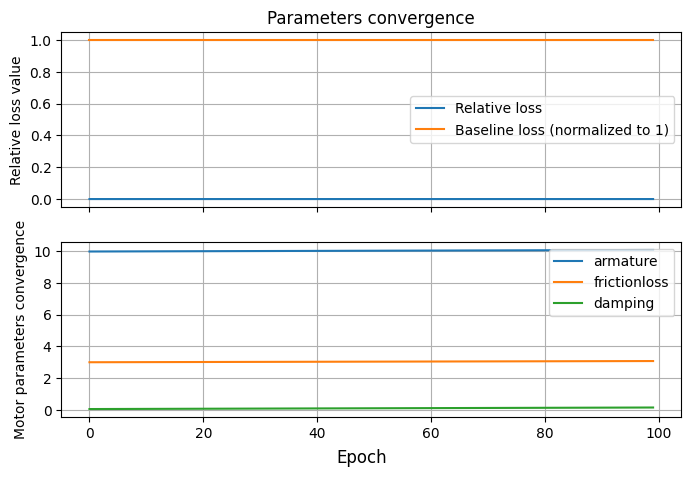

In [10]:
import matplotlib.pyplot as plt
import os, joblib

# Create a figure and gridspec with custom height ratios
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(8, 5), gridspec_kw={"height_ratios": [1, 1]}, sharex=True
)
# fig, ax1 = plt.subplots(1, 1, figsize=(8, 4.5))

# # Plot on the first (larger) subplot500
ax1.plot(adjusted_model_loss / baseline_loss, label="Relative loss")
ax1.plot(base_line, label="Baseline loss (normalized to 1)")
ax1.set_title("Parameters convergence")
ax1.set_ylabel("Relative loss value")
ax1.legend()
ax1.grid(True)

# Plot on the second (smaller) subplot
ax2.plot([p["armature"] for p in params_hist], label="armature")
ax2.plot([p["frictionloss"] for p in params_hist], label="frictionloss")
ax2.plot([p["damping"] for p in params_hist], label="damping")
ax2.set_ylabel("Motor parameters convergence")
ax2.legend()
ax2.grid(True)

# Set a shared x-axis label
fig.supxlabel("Epoch")
# fig.supylabel('Y-axis')


folder_path = os.path.join("assets/experiments", PARAMS.EXPERIMENT_NAME)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
img_path = os.path.join(folder_path, "pictures")
if not os.path.exists(img_path):
    os.makedirs(img_path)
joblib.dump(
    {
        "params": params_hist,
        "loss_hist": adjusted_model_loss,
        "baseline_loss": baseline_loss,
    },
    os.path.join(folder_path, "otimization_info.joblib"),
)

fig.savefig(
    os.path.join(img_path, "loss.png"),
    format="png",
    bbox_inches="tight",
)
fig.show()